In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import mglearn
from sklearn.decomposition import PCA
from itertools import repeat, product
%matplotlib inline


In [2]:
para = 0
for k in range(6, 12):
    n = 4**k * (1000 - k + 1) + 4**k
    para += n
para

5542576128

In [3]:
def initialize_diag_matrix(k):
    k = 4**k
    v = [1] * k
    D = np.diag(v)
    return D
    

In [4]:
class kmer_featurization:

  def __init__(self, k):
    """
    seqs: a list of DNA sequences
    k: the "k" in k-mer
    """
    self.k = k
    self.letters = ['A', 'T', 'C', 'G']
    self.multiplyBy = 4 ** np.arange(k-1, -1, -1) # the multiplying number for each digit position in the k-number system
    self.n = 4**k # number of possible k-mers

  def obtain_kmer_feature_for_a_list_of_sequences(self, seqs, write_number_of_occurrences=False):
    """
    Given a list of m DNA sequences, return a 2-d array with shape (m, 4**k) for the 1-hot representation of the kmer features.

    Args:
      write_number_of_occurrences:
        a boolean. If False, then in the 1-hot representation, the percentage of the occurrence of a kmer will be recorded; otherwise the number of occurrences will be recorded. Default False.    
    """
    kmer_features = []
    for seq in seqs:
      this_kmer_feature = self.obtain_kmer_feature_for_one_sequence(seq.upper(), write_number_of_occurrences=write_number_of_occurrences)
      kmer_features.append(this_kmer_feature)

    kmer_features = np.array(kmer_features)

    return kmer_features

  def obtain_kmer_feature_for_one_sequence(self, seq, write_number_of_occurrences=False):
    """
    Given a DNA sequence, return the 1-hot representation of its kmer feature.

    Args:
      seq: 
        a string, a DNA sequence
      write_number_of_occurrences:
        a boolean. If False, then in the 1-hot representation, the percentage of the occurrence of a kmer will be recorded; otherwise the number of occurrences will be recorded. Default False.
    """
    number_of_kmers = len(seq) - self.k + 1

    kmer_feature = np.zeros(self.n)

    for i in range(number_of_kmers):
      this_kmer = seq[i:(i+self.k)]
      this_numbering = self.kmer_numbering_for_one_kmer(this_kmer)
      kmer_feature[this_numbering] += 1

    if not write_number_of_occurrences:
      kmer_feature = kmer_feature / number_of_kmers

    return kmer_feature

  def kmer_numbering_for_one_kmer(self, kmer):
    """
    Given a k-mer, return its numbering (the 0-based position in 1-hot representation)
    """
    digits = []
    for letter in kmer:
      digits.append(self.letters.index(letter))

    digits = np.array(digits)

    numbering = (digits * self.multiplyBy).sum()

    return numbering


In [5]:
nucleotides = np.loadtxt('../R_outputs/promoters.csv', dtype=str)
# random1 = "A" * 1000
# random2 = "G" * 1000
# random3 = "C" * 1000
# random4 = "T" * 1000
# nucleotides = np.append(nucleotides, random1)
# nucleotides = np.append(nucleotides, random2)
# nucleotides = np.append(nucleotides, random3)
# nucleotides = np.append(nucleotides, random4)

In [6]:
def get_all_pos_kmers(k):
    letters = ['A', 'T', 'C', 'G']
    alphabet = []
    combinations = product(letters, repeat=k)
    for j in combinations:
        alphabet.append(''.join(j))
    return alphabet


In [7]:
def encode(nucleotides):

    encoded_nucleotides = []


    for nucleotide in nucleotides:

        encoded_nucleotide = []

        for k in range(1, 6):
            
            # create a list of possbile kmers
            alphabet = get_all_pos_kmers(k)
            
            # create a sparse matrix
            
            _sparse = initialize_diag_matrix(k)
    
            sparse = {}

            for i, kmer_1 in enumerate(alphabet):

                sparse[kmer_1] = {}

                for j, kmer_2 in enumerate(alphabet):

                    sparse[kmer_1][kmer_2] = _sparse[i, j]
            # kmer position
            
            for number_of_kmers in range(len(nucleotide) - k + 1):
                
                nucleotide_kmer = nucleotide[number_of_kmers:(number_of_kmers+k)]
                
                
                for kmer in alphabet:
                    
                    encoded_nucleotide.append(sparse[nucleotide_kmer][kmer])
             
            
            # kmer count
            obj = kmer_featurization(k) 
            
            kmer_feature = obj.obtain_kmer_feature_for_one_sequence(nucleotide, write_number_of_occurrences=True)
            
            encoded_nucleotide = list(kmer_feature) + encoded_nucleotide
            
            
        encoded_nucleotides.append(encoded_nucleotide)

    return np.array(encoded_nucleotides)

In [9]:
X = encode(nucleotides)

In [10]:
X.shape

(77, 1360356)

In [11]:
# PCA
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

In [16]:
# Label datapoints
label=[]
label.append(0)
label.append(1)
label.extend(repeat(2,75))
# label.append(1)
# label.append(2)
# label.append(3)
# label.append(4)

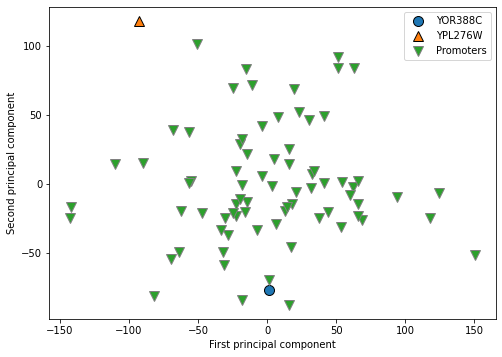

In [22]:
# plot first vs. second principal component, colored by class
plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], label)
plt.legend(["YOR388C", "YPL276W", "Promoters"], loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.savefig('./PCA.jpg', bbox_inches='tight', dpi=600)